## Curve fitting example with Covalent

To use this notebook, it is recommended to run everything in a clean `conda` environment. The environment can be created by using the provided `environment.yml` file at the root level.

### Create environment

```bash
conda env create --file environment.yml
```


### Start Covalent

```bash
covalent start --ignore-migrations
```

To for more verbose logging, `covalent` can be started in `DEBUG` mode

```bash
covalent start -d --ignore-migrations
```

In [1]:
import numpy as np
import covalent as ct
import matplotlib.pyplot as plt
from typing import List

### Raw code

```python
x = np.arange(10)
y = np.random.random(10)
```

### Fit
```python
fit = np.polyfit(x, y, 10)
xnew = np.linspace(x[0], x[-1], 50)
ynew = fit(xnew)
```


# plot
```python
fig, ax = plt.subplots()
plt.plot(x, y, 'o', xnew, ynew)
plt.xlim(x[0]-1, x[-1]+1)
```

### Functionalize the code (structured)

In [2]:
def fit_xy(x, y, order: int):
    z = np.polyfit(x, y, order)
    return np.poly1d(z)

def plot_fit(x, y, xnew, fit, order):
    ynew = fit(xnew)
    fig, ax = plt.subplots()
    plt.plot(x, y, 'o')
    plt.plot(xnew, ynew, '-')
    plt.xlim([x[0]-1, x[-1]+1])
    plt.xlabel(r"x", fontsize=14)
    plt.ylabel(f"Interpolant", fontsize=14)
    plt.title(f"Curve fit order: {order}", fontsize=14)
    return ax

def cfit(x, y, order):
    xnew = np.linspace(x[0], x[-1], 50)
    fit = fit_xy(x=x, y=y, order=order)
    return plot_fit(x=x, y=y, xnew=xnew, fit=fit, order=order)

## Covalentify workflow

### Make `fit_xy` electron

In [3]:
@ct.electron
def fit_xy(x, y, order):
   z = np.polyfit(x, y, order)
   return np.poly1d(z)

### Make an electron to plot the results

In [4]:
@ct.electron
def plot_fit(x, y, xnew, fit, order):
   ynew = fit(xnew)
   fig, ax = plt.subplots()
   plt.plot(x, y, 'o', color='r', ms=10, label=r'Data')
   plt.plot(xnew, ynew, '--', color='k', label=f'{order}th order polynomial fit')
   plt.xlim([x[0]-1, x[-1]+1])
   plt.xlabel(r"x", fontsize=14)
   plt.ylabel(f"Interpolant", fontsize=14)
   plt.title(f"Curve fitting with Covalent", fontsize=14)
   plt.legend(fontsize=12, ncols=2)
   plt.tight_layout()
   return ax

### Create lattice for curve fitting (workflow)

In [5]:
@ct.lattice
def cfit(x, y, order):
   xnew = np.linspace(x[0], x[-1], 100)
   fit = fit_xy(x=x, y=y, order=order)
   return plot_fit(x=x, y=y, xnew=xnew, fit=fit, order=order)

### Dispatch workflow to covalent server

* `N: size of the problem`
* `X => [0, N]`
* `Y => Randomly sampled between [0, 1] N times`
* `order: is degree of polynomial to use to fit the data, randomly chosen between [5, 10]`

In [6]:
x = np.arange(10)
y = np.random.random(10)
dispatch_id = ct.dispatch(cfit)(x = x, y = y, order=np.random.randint(5, 10))
print(dispatch_id)

52523f82-3b64-48ec-84c0-f7c834d675fb


[Covalent Server UI](http://localhost:48008)

## Get the workflow result

AxesSubplot(0.111372,0.131829;0.851421x0.78831)


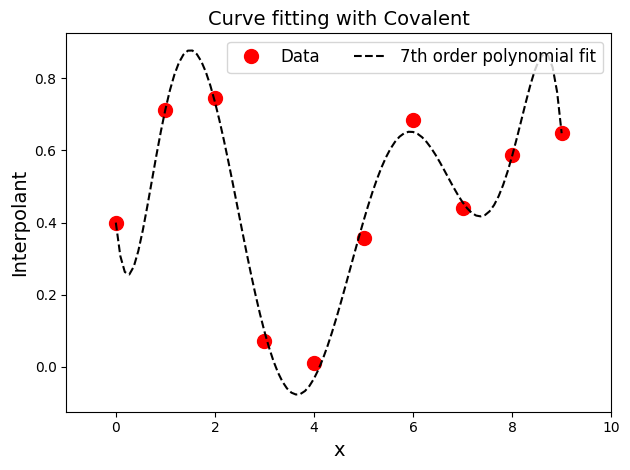

In [7]:
result = ct.get_result(dispatch_id=dispatch_id, wait=True)
print(result.result)

# Multiple dispatches

* Multiple curve fitting experiments
* Build the inputs as a `list`
* Dispatch each one to Covalent simultaneously

In [8]:
inputs = [{"x": np.arange(10), "y": np.random.random(10), "order": np.random.randint(5, 10)} for _ in range(10)]

In [10]:
dispatches = [ct.dispatch(cfit)(input["x"], input["y"], order=input["order"]) for input in inputs]

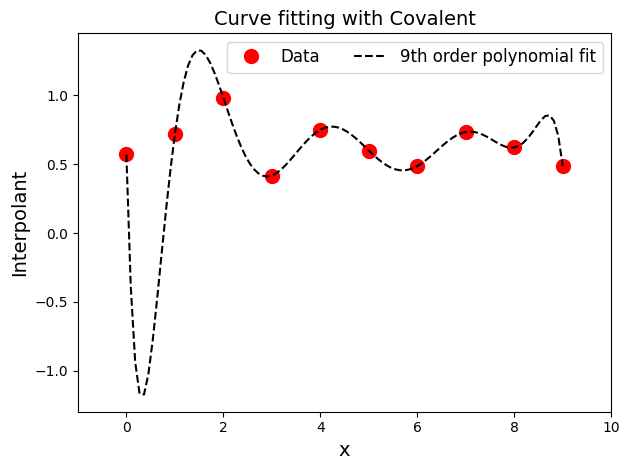

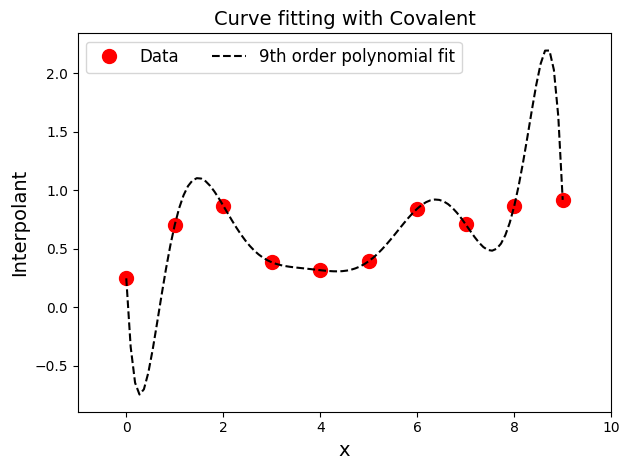

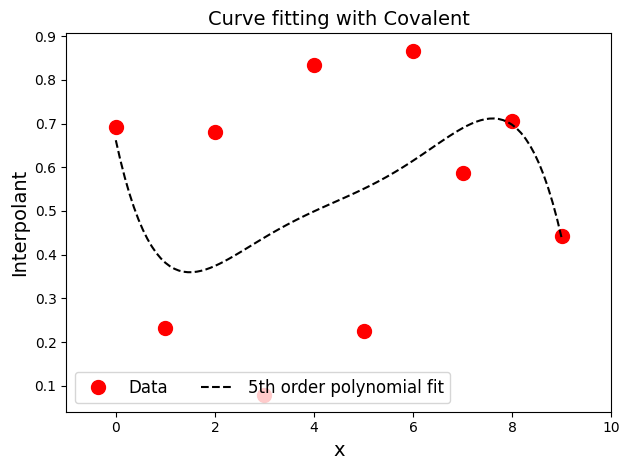

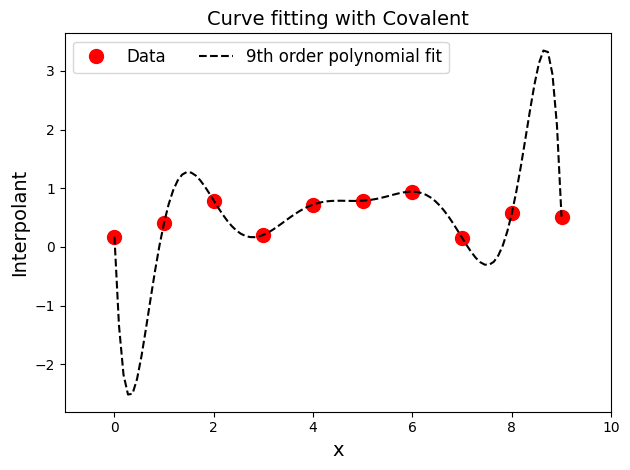

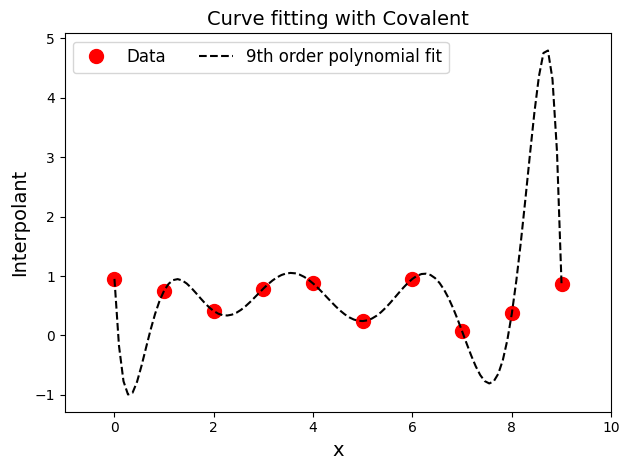

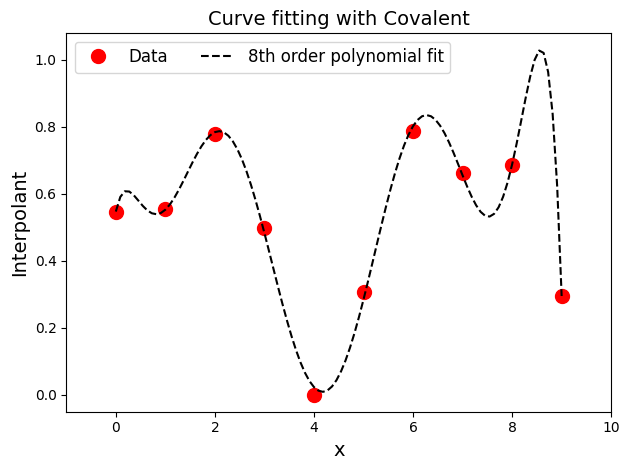

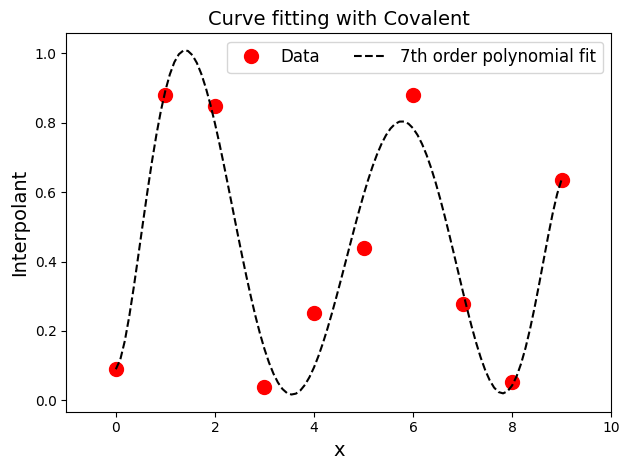

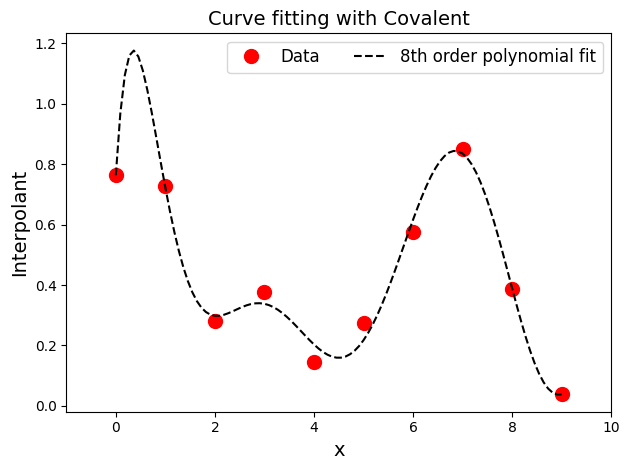

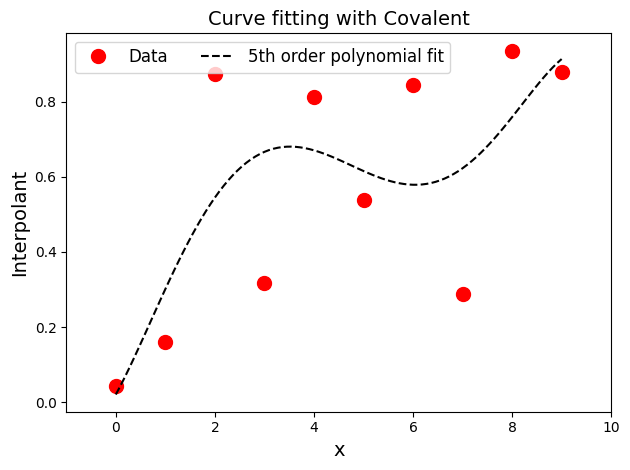

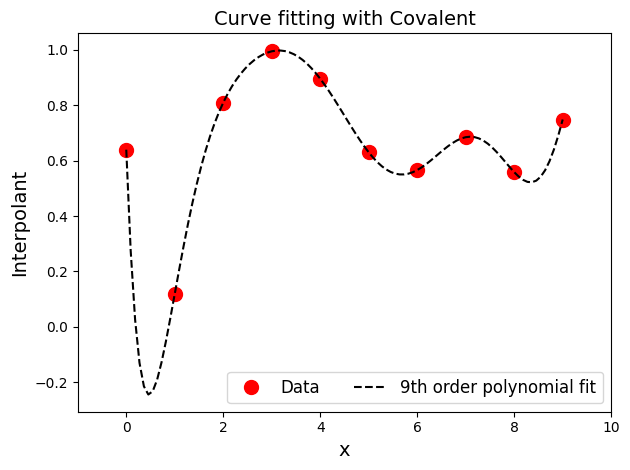

In [11]:
results = [ct.get_result(dispatch_id, wait=True).result for dispatch_id in dispatches]

# Sublattices

* Instead of create a multiple dispatches of the same workflow, it would be convenient to do a single dispatch of a larger workflow that invokes the original workflow
* Mark the first workflow as a `electron`
* Create a larger workflow that takes the space of parameters as an input
* Dispatch the new workflow

In [12]:
cfit_sublattice = ct.electron(cfit)

In [13]:
@ct.lattice
def multiple_curve_fits(inputs: List):
    all_results = []
    for input in inputs:
        result = cfit_sublattice(x=input["x"], y = input["y"], order=input["order"])
        all_results.append(result)
    return all_results

### Dispatch the larger workflow

In [14]:
inputs = [{"x": np.arange(10), "y": np.random.random(10), "order": np.random.randint(5, 10)} for _ in range(5)]
dispatch_id = ct.dispatch(multiple_curve_fits)(inputs)

In [15]:
results = ct.get_result(dispatch_id=dispatch_id, wait=True)

[<AxesSubplot: title={'center': 'Curve fitting with Covalent'}, xlabel='x', ylabel='Interpolant'>, <AxesSubplot: title={'center': 'Curve fitting with Covalent'}, xlabel='x', ylabel='Interpolant'>, <AxesSubplot: title={'center': 'Curve fitting with Covalent'}, xlabel='x', ylabel='Interpolant'>, <AxesSubplot: title={'center': 'Curve fitting with Covalent'}, xlabel='x', ylabel='Interpolant'>, <AxesSubplot: title={'center': 'Curve fitting with Covalent'}, xlabel='x', ylabel='Interpolant'>]


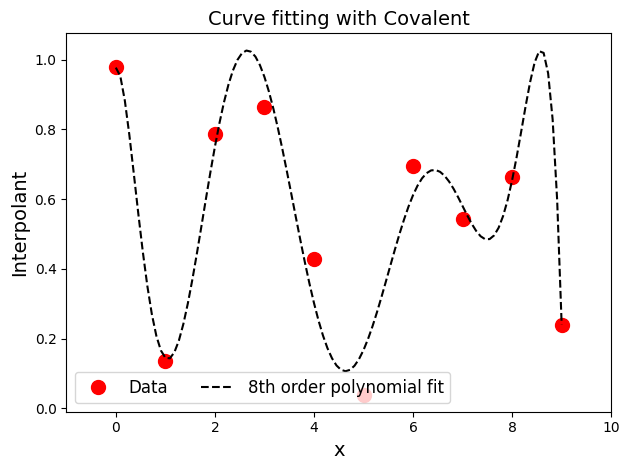

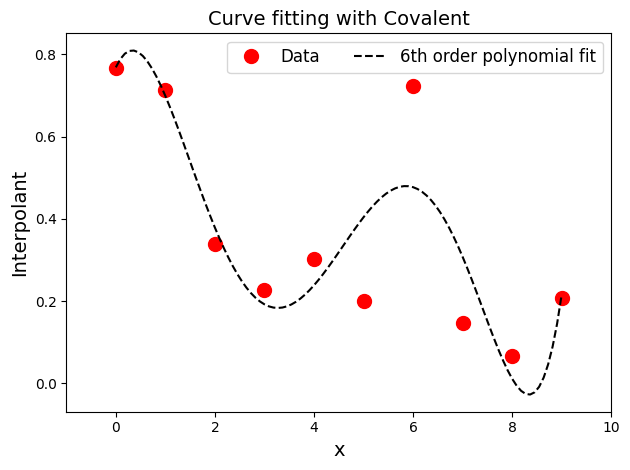

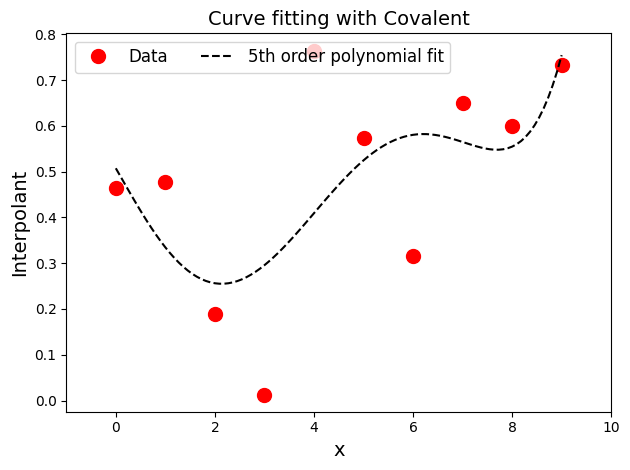

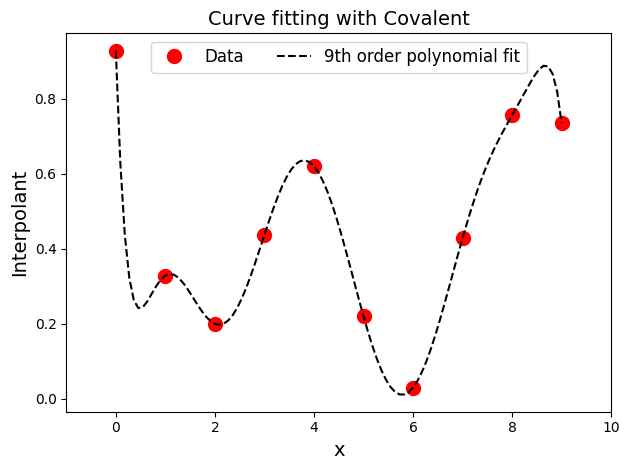

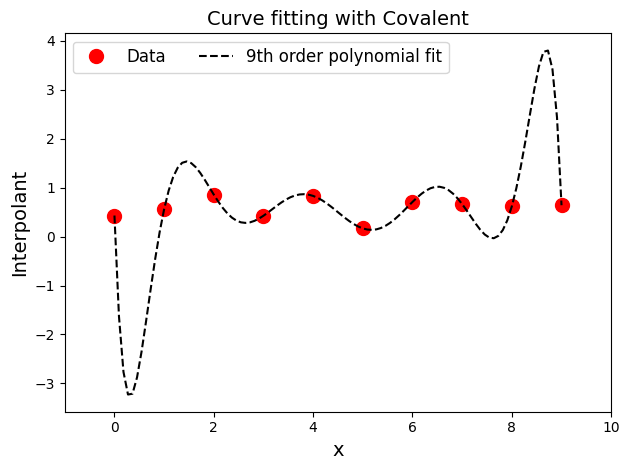

In [16]:
print(results.result)

### Result object

Stores all the metadata and necessary information about the workflow as a Python object. Users can use the result object API to query the status of running and completed workflows at a very granular level

In [20]:
x = np.arange(10)
y = np.random.random(10)
dispatch_id = ct.dispatch(cfit)(x = x, y = y, order = 10)
result = ct.get_result(dispatch_id, wait=True)

### Workflow status

In [26]:
print(result.status)

COMPLETED


### Retrive results of all nodes in the workflow

In [21]:
result.get_all_node_results()

[{'node_id': 0,
  'node_name': 'fit_xy',
  'start_time': datetime.datetime(2022, 9, 21, 16, 1, 3, 896363, tzinfo=datetime.timezone.utc),
  'end_time': datetime.datetime(2022, 9, 21, 16, 1, 3, 913981, tzinfo=datetime.timezone.utc),
  'status': 'COMPLETED',
  'output': <covalent.TransportableObject at 0x7f57f5522520>,
  'error': None,
  'sublattice_result': None,
  'stdout': '',
  'stderr': '/home/venkat/miniconda3/envs/ieee_covalent/lib/python3.8/site-packages/covalent/executor/base.py:95: RankWarning: Polyfit may be poorly conditioned\n  output = fn(*new_args, **new_kwargs)\n'},
 {'node_id': 1,
  'node_name': ':parameter:[0 1 2 3 4 5 6 7 8 9]',
  'start_time': datetime.datetime(2022, 9, 21, 16, 1, 3, 799796, tzinfo=datetime.timezone.utc),
  'end_time': datetime.datetime(2022, 9, 21, 16, 1, 3, 799798, tzinfo=datetime.timezone.utc),
  'status': 'COMPLETED',
  'output': <covalent.TransportableObject at 0x7f57f55225e0>,
  'error': None,
  'sublattice_result': None,
  'stdout': None,
  'std

### Workflow execution time

In [25]:
duration = result.end_time - result.start_time
print(duration.total_seconds())

0.280327


### Query individual node outputs/metadata

In [32]:
result.get_node_result(0)

{'node_id': 0,
 'node_name': 'fit_xy',
 'start_time': datetime.datetime(2022, 9, 21, 16, 1, 3, 896363, tzinfo=datetime.timezone.utc),
 'end_time': datetime.datetime(2022, 9, 21, 16, 1, 3, 913981, tzinfo=datetime.timezone.utc),
 'status': 'COMPLETED',
 'output': <covalent.TransportableObject at 0x7f57f5544d00>,
 'error': None,
 'sublattice_result': None,
 'stdout': '',
 'stderr': '/home/venkat/miniconda3/envs/ieee_covalent/lib/python3.8/site-packages/covalent/executor/base.py:95: RankWarning: Polyfit may be poorly conditioned\n  output = fn(*new_args, **new_kwargs)\n'}